## Imports and upload data


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy as cp
import scipy
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
!rm *.csv

from google.colab import files
#NOT NORMALIZED
print("Please load the raw csv data")
uploadedData = files.upload()
filename = list(uploadedData)[0]
td_raw = pd.read_csv(filename)

Please load the raw csv data


Saving preprocessed_train.csv to preprocessed_train.csv


In [ ]:
#NORMALIZED
print("Please load the raw csv data")
uploadedData = files.upload()
filename = list(uploadedData)[0]
td = pd.read_csv(filename)

## Transform target labels into numerical values.

In [ ]:
targets_col = ['spread', 'risk', 'covid']

def label_to_int(val):
  return 1 if (val=='High' or val=='True') else -1

def transform_labels(data):
  for target in targets_col:
    data[target] = data[target].astype(str).apply(lambda x : label_to_int(x))
  return data

td_raw = transform_labels(td_raw)
td = transform_labels(td)

#Drop numeration column
td_raw.drop('Unnamed: 0', axis= 1, inplace = True)
td.drop('Unnamed: 0', axis= 1, inplace = True)

## Visualization function for classifiers:

In [ ]:
def visualize_clf(clf, X, Y, x_step, y_step, labels, title, figure_size=8, marker_size=250):
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap

    plt.figure(figsize=(figure_size, figure_size))

    # Parameters
    n_classes = 2
    markers = ["P", "v"]
    palette = sns.color_palette("hls", 2)
    custom_cmap = ListedColormap(palette.as_hex())
    plot_step = 0.02

    x_delta = np.abs(X[:, 0].max() - X[:, 0].min()) * 0.1
    y_delta = np.abs(X[:, 1].max() - X[:, 1].min()) * 0.1
    x_min, x_max = X[:, 0].min() - x_delta, X[:, 0].max() + x_delta
    y_min, y_max = X[:, 1].min() - y_delta, X[:, 1].max() + y_delta
    xx, yy = np.meshgrid(np.arange(x_min, x_max, x_step),
                         np.arange(y_min, y_max, y_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cs = plt.contourf(xx, yy, Z, cmap=custom_cmap, alpha=0.35)

    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.grid(alpha=0.75)

    # Plot the training points
    for i, color, marker in zip(labels, palette, markers):
        idx = np.where(Y == i)
        plt.scatter(X[idx, 0], X[idx, 1], color=color,
                    marker=marker,
                    edgecolor='white', s=marker_size)

    plt.title(title, fontsize=20)
    plt.axis("tight")
    plt.show()

## KNN

In [ ]:
from sklearn.base import BaseEstimator,ClassifierMixin

class kNN(BaseEstimator, ClassifierMixin):
  def __init__(self, n_neighbors:int = 5):
    self.n_neighbors = n_neighbors
  
  def fit(self, X, y):
    self.X_set = np.copy(X)
    self.y_label = np.copy(y)
    return self
    
  def predict(self, X):
    train_X, y = self.X_set, self.y_label
    predictions = None
    # Compute the predicted labels (+1 or -1)
    dist_mat = scipy.spatial.distance.cdist(X, train_X, metric='euclidean')
    top_k = [np.argsort(x, kind = 'quick_sort')[:self.n_neighbors] for x in dist_mat]
    top_k_labels = np.array([y[i] for i in top_k])
    # Most common label:
    predictions = [Counter(labels).most_common(1)[0][0] for labels in top_k_labels]
    return np.array(predictions)

## Toy dataset

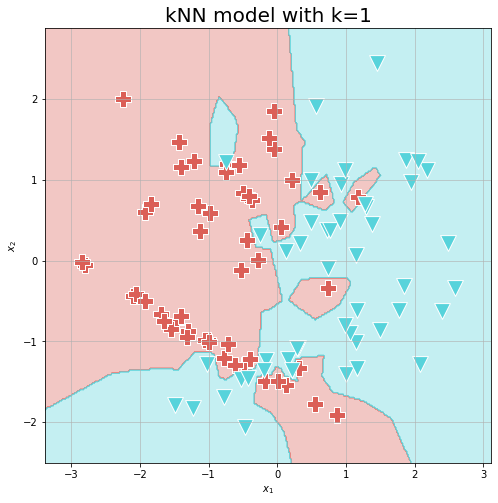

In [ ]:
import sklearn.datasets
state = 14
X_toy, y_toy = sklearn.datasets.make_classification(n_samples=100, n_features=2, random_state=state, flip_y = 0.1, n_informative=2, n_redundant=0)


## KNN visualizations

In [ ]:
knn1 = kNN(1)
knn1.fit(X_toy, y_toy)
visualize_clf(knn1, X_toy, y_toy, 0.02, 0.02, [0, 1], 'kNN model with k=1', marker_size=250)

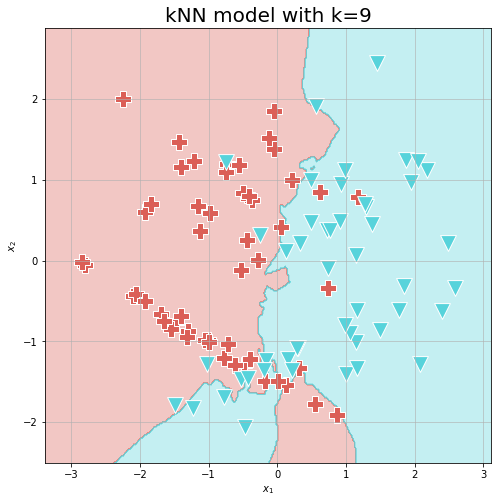

In [ ]:
knn1 = kNN(9)
knn1.fit(X_toy, y_toy)
visualize_clf(knn1, X_toy, y_toy, 0.02, 0.02, [0, 1],'kNN model with k=9', marker_size=250)

## More on data exploration:

In [ ]:
# 10 most correlated fratures to spread.
s = td_raw.corr().spread.abs()
s.sort_values(kind="quicksort", ascending=False)[0:11]

spread              1.000000
PCR_10              0.195759
PCR_07              0.061466
sport_activity      0.048737
A+                  0.038540
O+                  0.035753
fever               0.031172
low_appetite        0.028148
PCR_02              0.027831
household_income    0.026970
cough               0.025142
Name: spread, dtype: float64

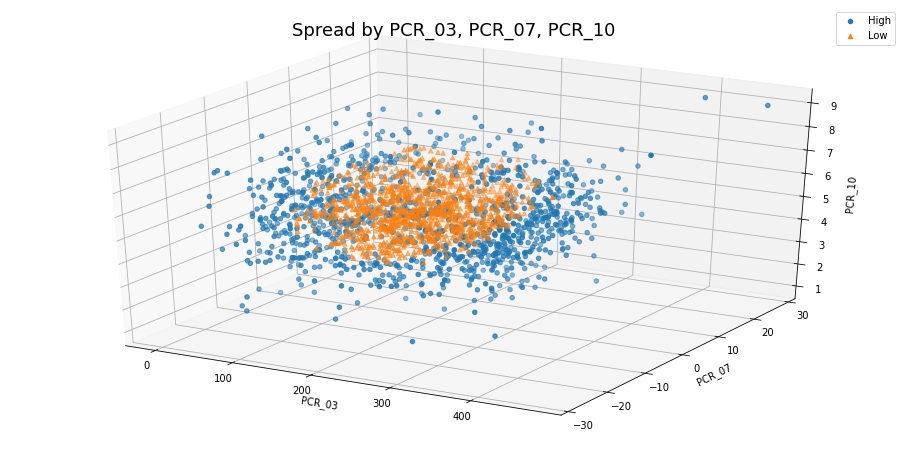

In [ ]:
# spread distribution by PCR values.
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(projection='3d')

for target_val, m, risk_val in [(1,'o', 'High'), (-1,'^', 'Low')]:
  x = td_raw[td_raw['spread'] == target_val]['PCR_03']
  y = td_raw[td_raw['spread'] == target_val]['PCR_07']
  z = td_raw[td_raw['spread'] == target_val]['PCR_10']
  ax.scatter(x, y, z, marker=m, label=risk_val)

ax.set_xlabel('PCR_03')
ax.set_ylabel('PCR_07')
ax.set_zlabel('PCR_10')
ax.legend()
ax.set_title('Spread by PCR_03, PCR_07, PCR_10', fontsize=18)
plt.show()

## Comparing spread prediction of KNN(11) before and after normalization of PCR values. 

In [ ]:
X5 = cp.deepcopy(td_raw[['PCR_03', 'PCR_07', 'PCR_10']].to_numpy())
spread_labels = cp.deepcopy(td_raw['spread'].to_numpy())
knn5 = kNN(11)
knn5.fit(X5, spread_labels)
knn5.score(X5, spread_labels)

0.81125

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

z_scaler = StandardScaler()
X7 = z_scaler.fit_transform(X5)
knn7 = kNN(11)
knn7.fit(X7, spread_labels)
knn7.score(X7, spread_labels)

0.9225

## Cross validation of KNN k parameter

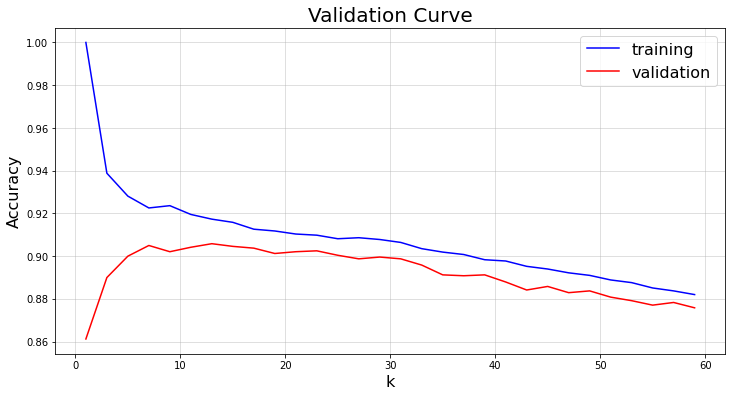

In [ ]:
from sklearn.model_selection import cross_validate

params = range(1,61,2)
train_scores = []
valid_scores = []

for k in params:
  scores = cross_validate(kNN(k), X7, spread_labels, scoring='accuracy', cv=8, return_train_score=True)
  train_scores.append(np.mean(scores['train_score']))
  valid_scores.append(np.mean(scores['test_score']))

_, ax = plt.subplots(figsize=(12, 6))

ax.plot(params, train_scores, color='blue', label='training')
ax.plot(params, valid_scores, color='red', label='validation')
ax.set_title('Validation Curve', fontsize=20)
ax.set_xlabel('k', fontsize=16)
ax.set_ylabel('Accuracy', fontsize=16)
_ = ax.legend(prop={"size":16})

plt.grid(alpha=0.5)
plt.show()

## Evaluation of optimal KNN:

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
k_opt = 8

spread_pred = cross_val_predict(kNN(k_opt), X7, spread_labels, cv=8)
conf_mat = confusion_matrix(spread_labels, spread_pred)
conf_mat

array([[1133,   66],
       [ 168, 1033]])

## Decision Tree Classifier

In [ ]:
# Most correlated to risk target value:
s = td.corr().risk.abs()
s.sort_values(kind="quicksort", ascending=False)[0:11]

risk              1.000000
sugar_levels      0.280077
PCR_06            0.209260
weight            0.147782
sport_activity    0.111642
zip               0.048972
fever             0.041673
PCR_01            0.040067
PCR_07            0.031165
A-                0.029820
O-                0.028531
Name: risk, dtype: float64

## Decision Tree visualization:

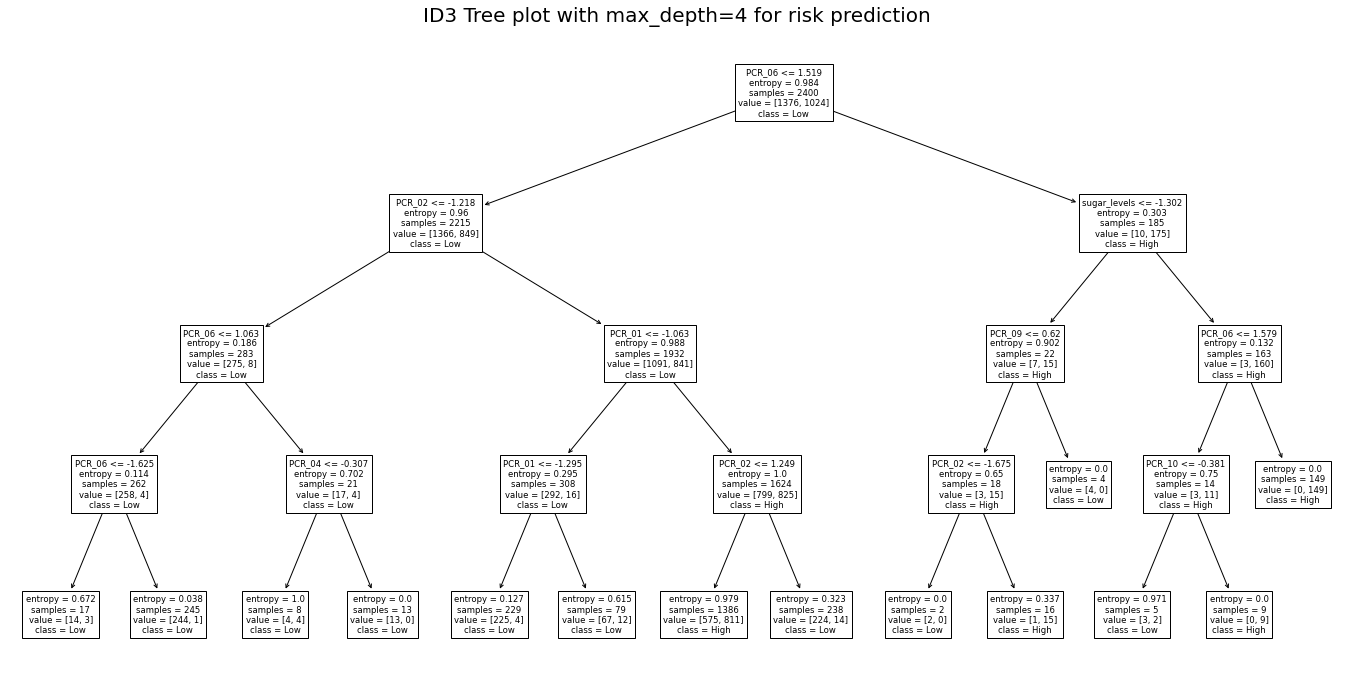

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
targets = ['spread', 'risk', 'covid']

x_cols = list(set(td.columns) - set(targets))
X13 = td[x_cols]
y13 = td['risk']
tree = DecisionTreeClassifier(criterion='entropy', max_depth=4)
tree.fit(X13, y13)
tree.score(X13, y13)

plt.figure(figsize=(24,12))
plot_tree(tree, feature_names=x_cols, class_names=['High' if str(x)=='1' else 'Low' for x in tree.classes_]) 
plt.title('ID3 Tree plot with max_depth=4 for risk prediction', fontsize=20)
plt.show()

In [ ]:
tree.score(X13, y13)

0.7433333333333333

## Decision Tree CV:

In [ ]:
from sklearn.model_selection import GridSearchCV
max_depth_range = range(3, 20, 1)
min_samples_leaf_range = range(1, 26, 1)
tree_params = {'max_depth': max_depth_range, 'min_samples_leaf': min_samples_leaf_range}
GSCVClf = GridSearchCV(DecisionTreeClassifier(criterion='entropy'), tree_params, cv = 8, return_train_score = True)
GSCVClf.fit(X13, y13)
cv_results = GSCVClf.cv_results_

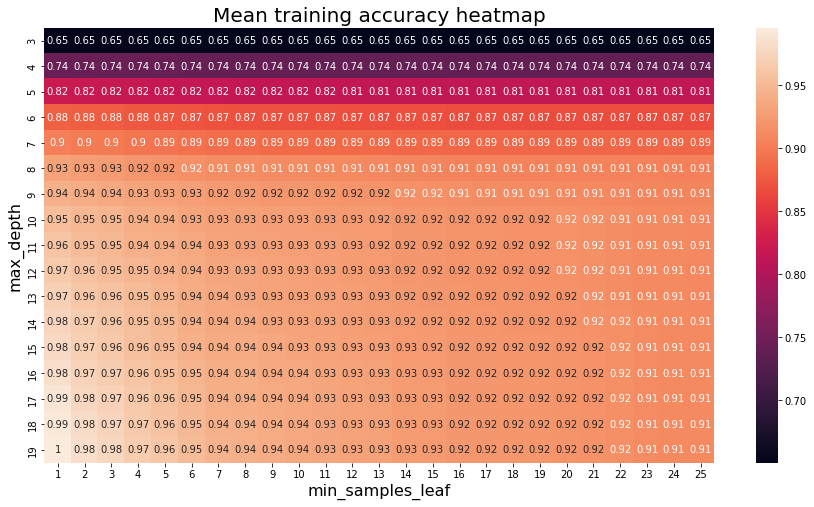

In [ ]:
cv_data = cv_results['mean_train_score'].reshape(len(max_depth_range), len(min_samples_leaf_range))
plt.figure(figsize=(15,8))
ax = plt.axes()
sns.heatmap(cv_data, xticklabels=min_samples_leaf_range, yticklabels=max_depth_range, annot=True).set_title('Mean training accuracy heatmap', fontsize=20)
ax.set_xlabel('min_samples_leaf', fontsize=16)
ax.set_ylabel('max_depth', fontsize=16)
plt.show()

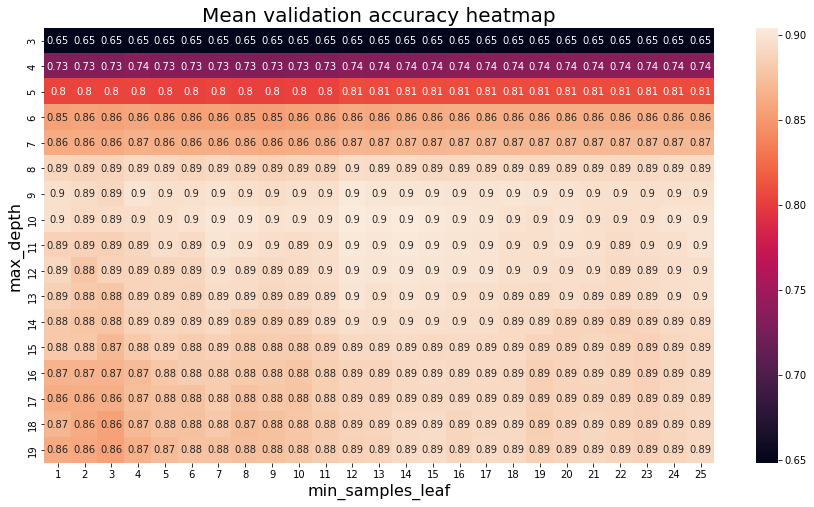

In [ ]:
cv_data = cv_results['mean_test_score'].reshape(len(max_depth_range), len(min_samples_leaf_range))
plt.figure(figsize=(15,8))
ax = plt.axes()
sns.heatmap(cv_data, xticklabels=min_samples_leaf_range, yticklabels=max_depth_range, annot=True).set_title('Mean validation accuracy heatmap', fontsize=20)
ax.set_xlabel('min_samples_leaf', fontsize=16)
ax.set_ylabel('max_depth', fontsize=16)
plt.show()

## Soft SVM


In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np

class SoftSVM(BaseEstimator, ClassifierMixin):
    """
    Custom C-Support Vector Classification.
    """
    def __init__(self, C: float, lr: float = 1e-5):
        """
        Initialize an instance of this class.
        :param C: inverse strength of regularization. Must be strictly positive.
        :param lr: the SGD learning rate (step size)
        """
        self.C = C
        self.lr = lr
        self.batch_size = 32
        self.w = None
        self.b = 0.0

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        :param n_features:
        """
        self.w = np.random.randn(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, C: float, X, y):
        """
        Compute the SVM objective loss.

        :param w: weight vector for linear classification; array of shape (n_features,)
        :param b: bias scalar for linear classification
        :param C: inverse strength of regularization. Must be strictly positive.
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the Soft SVM objective loss (float scalar)
        """
        margins = (X.dot(w) + b).reshape(-1, 1)
        hinge_inputs = np.multiply(margins, y.reshape(-1, 1))

        norm = np.linalg.norm(w)

        # complete the loss calculation
        loss = 0.0
        loss = np.square(norm) + C * np.sum(np.maximum(0, 1 - hinge_inputs))
        return loss

    @staticmethod
    def subgradient(w, b: float, C: float, X, y):
        """
        Compute the (analytical) SVM objective sub-gradient.

        :param w: weight vector for linear classification; array of shape (n_features,)
        :param b: bias scalar for linear classification
        :param C: inverse strength of regularization. Must be strictly positive.
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        # calculate the analytical sub-gradient of soft-SVM w.r.t w and b
        g_w = None
        g_b = 0.0
        
        margins = (X.dot(w) + b).reshape(-1, 1)
        z = np.multiply(margins, y.reshape(-1, 1))
        f_z = np.asarray([-1 if zi < 1 else 0 for zi in z]).reshape(-1, 1)
        f_z_y = np.multiply(f_z, y.reshape(-1, 1)).reshape(-1, 1)
        g_w = 2 * w + C * np.sum(np.multiply(f_z_y, X), axis = 0)

        g_b = C * np.sum(np.multiply(f_z, y.reshape(-1, 1)))

        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 2000, keep_losses: bool = True):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses:
        :return: the training losses and accuracies during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        losses = []
        accuracies = []

        if keep_losses:
            losses.append(self.loss(self.w, self.b, self.C, X, y))
            accuracies.append(self.score(X, y))

        # Iterate over batches
        for iter in range(0, max_iter):
            start_idx = (iter * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx: end_idx]
            batch_y = y[start_idx: end_idx]

            # Compute the (sub)gradient of the current *batch*
            g_w, g_b = SoftSVM.subgradient(self.w, self.b, self.C, batch_X, batch_y)

            # Perform a (sub)gradient step
            # update the learned parameters correctly
            self.w = self.w - self.lr * g_w
            self.b = self.b - self.lr * g_b

            if keep_losses:
                losses.append(self.loss(self.w, self.b, self.C, X, y))
                accuracies.append(self.score(X, y))

        return losses, accuracies

    def fit(self, X, y, max_iter: int = 2000):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Perform classification on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted class labels for samples in X; array of shape (n_samples,)
        """
        # compute the predicted labels (+1 or -1)
        y_pred = None
        y_pred = np.asarray([1 if (x.dot(self.w) + self.b) >= 0 else -1 for x in X])
        return y_pred


## SVM subgradient implementation:

In [ ]:
def numerical_subgradient(w, b, C, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = SoftSVM.loss(w_, b, C, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = SoftSVM.loss(w_, b, C, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (SoftSVM.loss(w_, b + delta, C, X, y) - orig_objective) / delta
    return g_w, g_b



def compare_gradients(X, y, deltas, C=1, REPEATS=100, figsize=(10, 6)):
    residual_means = []

    for delta in deltas:
        residuals = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad = SoftSVM.subgradient(w, b, C, X, y)[0]
            numeric_grad = numerical_subgradient(w, b, C, X, y, delta=delta)[0]

            residual = np.linalg.norm(numeric_grad - analytic_grad)
            residuals.append(residual)

        residual_means.append(np.mean(residuals))

    plt.figure(figsize=figsize)
    plt.title('Residuals of analytical and numerical gradients', fontsize=22)
    plt.plot(deltas, residual_means, linewidth=3)      
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('$\delta$', fontsize=18)
    plt.ylabel('dist(analytic, numeric$_\delta$)', fontsize=18)
    plt.ylabel(r'$\left\Vert \nabla_{w}p_{C}\left(w,b\right) - u_{\delta} \left(w,b\right)\right\Vert$', fontsize=18)

    plt.grid(alpha=0.5)
    plt.show()


## Evaluating gradient implementation

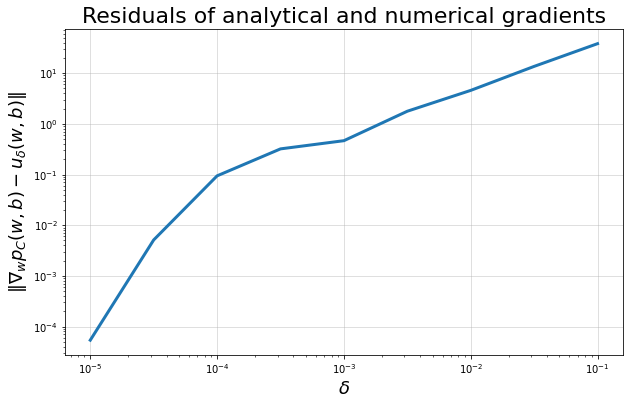

In [ ]:
targets = ['spread', 'risk', 'covid']
x_cols = list(set(td.columns) - set(targets))
X16 = td[x_cols]

compare_gradients(X16.to_numpy(), td['covid'].to_numpy(), deltas=np.logspace(-5, -1, 9))



## Soft SVM learning curve

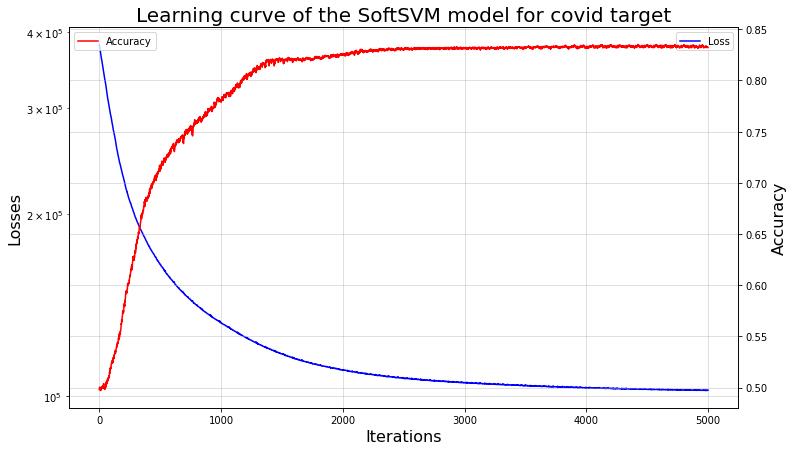

In [ ]:
SoftSVM_clf = SoftSVM(C=1e2, lr=1e-5)
losses, accuracies = SoftSVM_clf.fit_with_logs(X16.to_numpy(), td['covid'].to_numpy(), max_iter=5000)

fig = plt.figure(figsize=(12, 7))
ax1 = fig.add_subplot(111)
line1 = ax1.semilogy(losses, c='b', label='Loss')
ax1.set_xlabel('Iterations', fontsize=16)
ax1.set_ylabel('Losses', fontsize=16)
plt.legend()
ax1.grid(alpha=0.5)
ax2 = ax1.twinx()
line2 = ax2.plot(accuracies, c='r', label='Accuracy')
ax2.set_ylabel('Accuracy', fontsize=16)
plt.legend()
ax2.grid(alpha=0.5)
plt.title('Learning curve of the SoftSVM model for covid target', fontsize=20)
plt.show()

## Soft SVM with polynomial features.
### - Determining optimal lr.

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures

pol_degree = 2
C = 1000
max_iter = 2000
folds = 8
poly = PolynomialFeatures(degree = pol_degree )

X19 = poly.fit_transform(X7)

lr_range = np.logspace(-10, -1, 10)
train_scores = []
valid_scores = []

for lr in lr_range:
  SoftSVM_clf = SoftSVM(C = C, lr = lr)
  scores = cross_validate(SoftSVM_clf, X19, spread_labels, scoring='accuracy', cv = folds, return_train_score=True)
  train_scores.append(np.mean(scores['train_score']))
  valid_scores.append(np.mean(scores['test_score']))



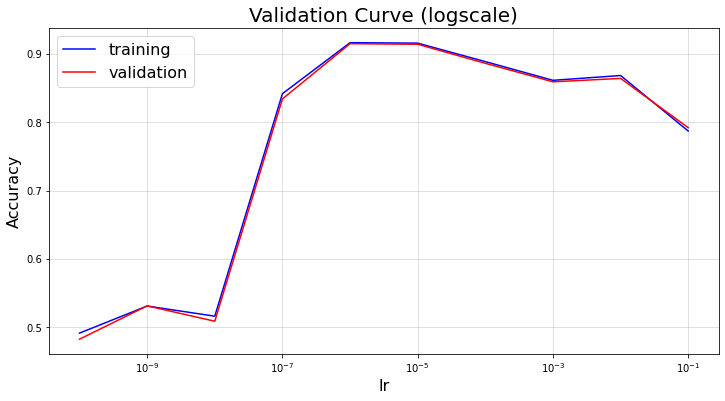

In [ ]:
_, ax = plt.subplots(figsize=(12, 6))

ax.plot(lr_range, train_scores, color='blue', label='training')
ax.plot(lr_range, valid_scores, color='red', label='validation')
ax.set_title('Validation Curve (logscale)', fontsize=20)
ax.set_xlabel('lr', fontsize=16)
ax.set_ylabel('Accuracy', fontsize=16)
_ = ax.legend(prop={"size":16})
plt.xscale('log')
plt.grid(alpha=0.5)
plt.show()